### Import

In [1]:
import os
import joblib
import datetime
from tqdm import tqdm

# Preprocessing
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

# Torch-related
import torch
from pytorch_model_summary import summary
from transformers import AutoTokenizer

# Custom defined
from config import pre_train, fine_tuning
from libs.data import load_dataset, collate_fn
from architecture.architecture import *
from architecture.shared_module import patchify

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
is_test_mode = False
is_new_rawdata = False
is_new_dataset = False
config = pre_train
# config = fine_tuning

device = torch.device("cuda")
# device = torch.device("cpu")

if is_new_dataset:
    train_dataset = load_dataset(is_test_mode, is_new_rawdata, config, mode="pre_train", verbose=True)
    # train_dataset = load_dataset(is_test_mode, is_new_rawdata, config, mode="fine_tuning", verbose=True)
else:
    suffix = "_test" if is_test_mode else ""
    train_dataset = torch.load(f"src/pre_train_dataset{suffix}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config), pin_memory=True, num_workers=16, prefetch_factor=32)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config))
for _ in train_dataloader:
    [print(key, val.shape) for key, val in _.items() if "scaler" not in key and "raw" not in key]
    break

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([32, 300, 1])
day torch.Size([32, 300])
dow torch.Size([32, 300])
month torch.Size([32, 300])
holiday torch.Size([32, 300])
price torch.Size([32, 300, 1])
temporal_mask torch.Size([32, 300])
target_fcst_mask torch.Size([32, 300])
img_path torch.Size([32, 3, 224, 224])
detail_desc torch.Size([32, 62])
detail_desc_remain_mask torch.Size([32, 16])
detail_desc_masked_mask torch.Size([32, 46])
detail_desc_revert_mask torch.Size([32, 62])
detail_desc_remain_idx torch.Size([32, 16])
detail_desc_masked_idx torch.Size([32, 46])
detail_desc_revert_idx torch.Size([32, 62])


# Pre-Train

In [3]:
label_encoder_dict = joblib.load("src/label_encoder_dict.pkl")
model = MaskedBlockAutoencoder(config, label_encoder_dict)
model.to(device)
summary(model, _, device, show_parent_layers=True, print_summary=True)
""

-----------------------------------------------------------------------------------------------------
            Parent Layers          Layer (type)          Output Shape         Param #     Tr. Param #
   MaskedBlockAutoencoder         MBAEEncoder-1     [32, 300, 2, 384]      33,446,784      33,371,520
   MaskedBlockAutoencoder         MBAEDecoder-2                            11,815,359      11,777,727
   MaskedBlockAutoencoder             MSELoss-3             [32, 300]               0               0
   MaskedBlockAutoencoder    CrossEntropyLoss-4                [9600]               0               0
Total params: 45,262,143
Trainable params: 45,149,247
Non-trainable params: 112,896
-----------------------------------------------------------------------------------------------------


''

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:

loss_li_dict, mean_loss_li_dict = defaultdict(list), defaultdict(list)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def get_loss_lists(loss, loss_dict):
    loss_li_dict["total"].append(loss.item())
    loss_li_dict.update({key:val.item() for key, val in loss_dict.items()})

    for key, val in loss_li_dict.items():
        mean_loss_li_dict[key].append(np.array(val).mean())

def plot_sample(output_dict, data_dict, loss_dict, ca_weight_dict):
    nrows, ncols = 12, 4
    idx, plot_idx = 0, 1
    plt.figure(figsize=(25,25))

    # Total loss
    plt.subplot(nrows, ncols, plot_idx)
    plt.plot(loss_dict["total"])
    plt.title(f"total: {loss_dict['total'][-1]}"); plot_idx += 4

    # Plot temporal
    for n, col in enumerate(config.temporal_cols):
        ### Loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(loss_dict[col]); plot_idx += 1
        plt.title(f"{col}: {loss_dict[col][-1]}")
        ### Sample
        pred, y = output_dict[col].detach().cpu()[idx].squeeze(), data_dict[col][idx].squeeze()
        pred = torch.argmax(pred, dim=-1) if col in config.embedding_cols else pred
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(y)
        plt.plot(pred); plot_idx += 1
        ### Weight
        if n > 0: plot_idx += 2; continue
        ca_weight = ca_weight_dict["temporal"].detach().cpu()[idx].mean(dim=0) # Mean through time steps
        start_idx = 0
        
        for col in ["temporal"] + config.img_cols + config.nlp_cols:
            length = ca_weight_dict[col].shape[1]
            if col == "temporal": start_idx += length; continue
            weight = ca_weight[start_idx:start_idx+length]
            plt.subplot(nrows, ncols, plot_idx)
            
            if col in config.img_cols:
                plt.imshow(weight.reshape(224//config.patch_size, 224//config.patch_size)); plot_idx += 1
            elif col in config.nlp_cols:
                os.environ["TOKENIZERS_PARALLELISM"] = "false"
                xlabel = tokenizer.tokenize(tokenizer.decode(data_dict[col][idx]))
                os.environ["TOKENIZERS_PARALLELISM"] = "true"
                df = pd.DataFrame({"xlabel":xlabel, "weight":weight})
                df = df[df["xlabel"]!="[PAD]"]
                sns.barplot(df["weight"]); plot_idx += 1
                plt.gca().set_xticklabels(df["xlabel"], rotation=90)
            start_idx += length
    
    # Plot img
    for n, col in enumerate(config.img_cols):
        ### Loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(loss_dict[col]); plot_idx += 1
        plt.title(f"{col}: {loss_dict[col][-1]}")
        ### Sample
        pred, y = output_dict[col].detach().cpu().squeeze(), data_dict[col].squeeze()
        pred, y = unpatchify(pred).permute(0,2,3,1)[idx], y.permute(0,2,3,1)[idx]

        plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
        plt.imshow(y)
        plt.subplot(nrows, ncols, plot_idx); plot_idx += 1
        plt.imshow(pred)
    plot_idx += 1

    # Plot nlp
    for n, col in enumerate(config.nlp_cols):
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(loss_dict[col]); plot_idx += 1
        plt.title(f"{col}: {loss_dict[col][-1]}")
    
    clear_output(wait=True)
    plt.tight_layout()
    plt.show()

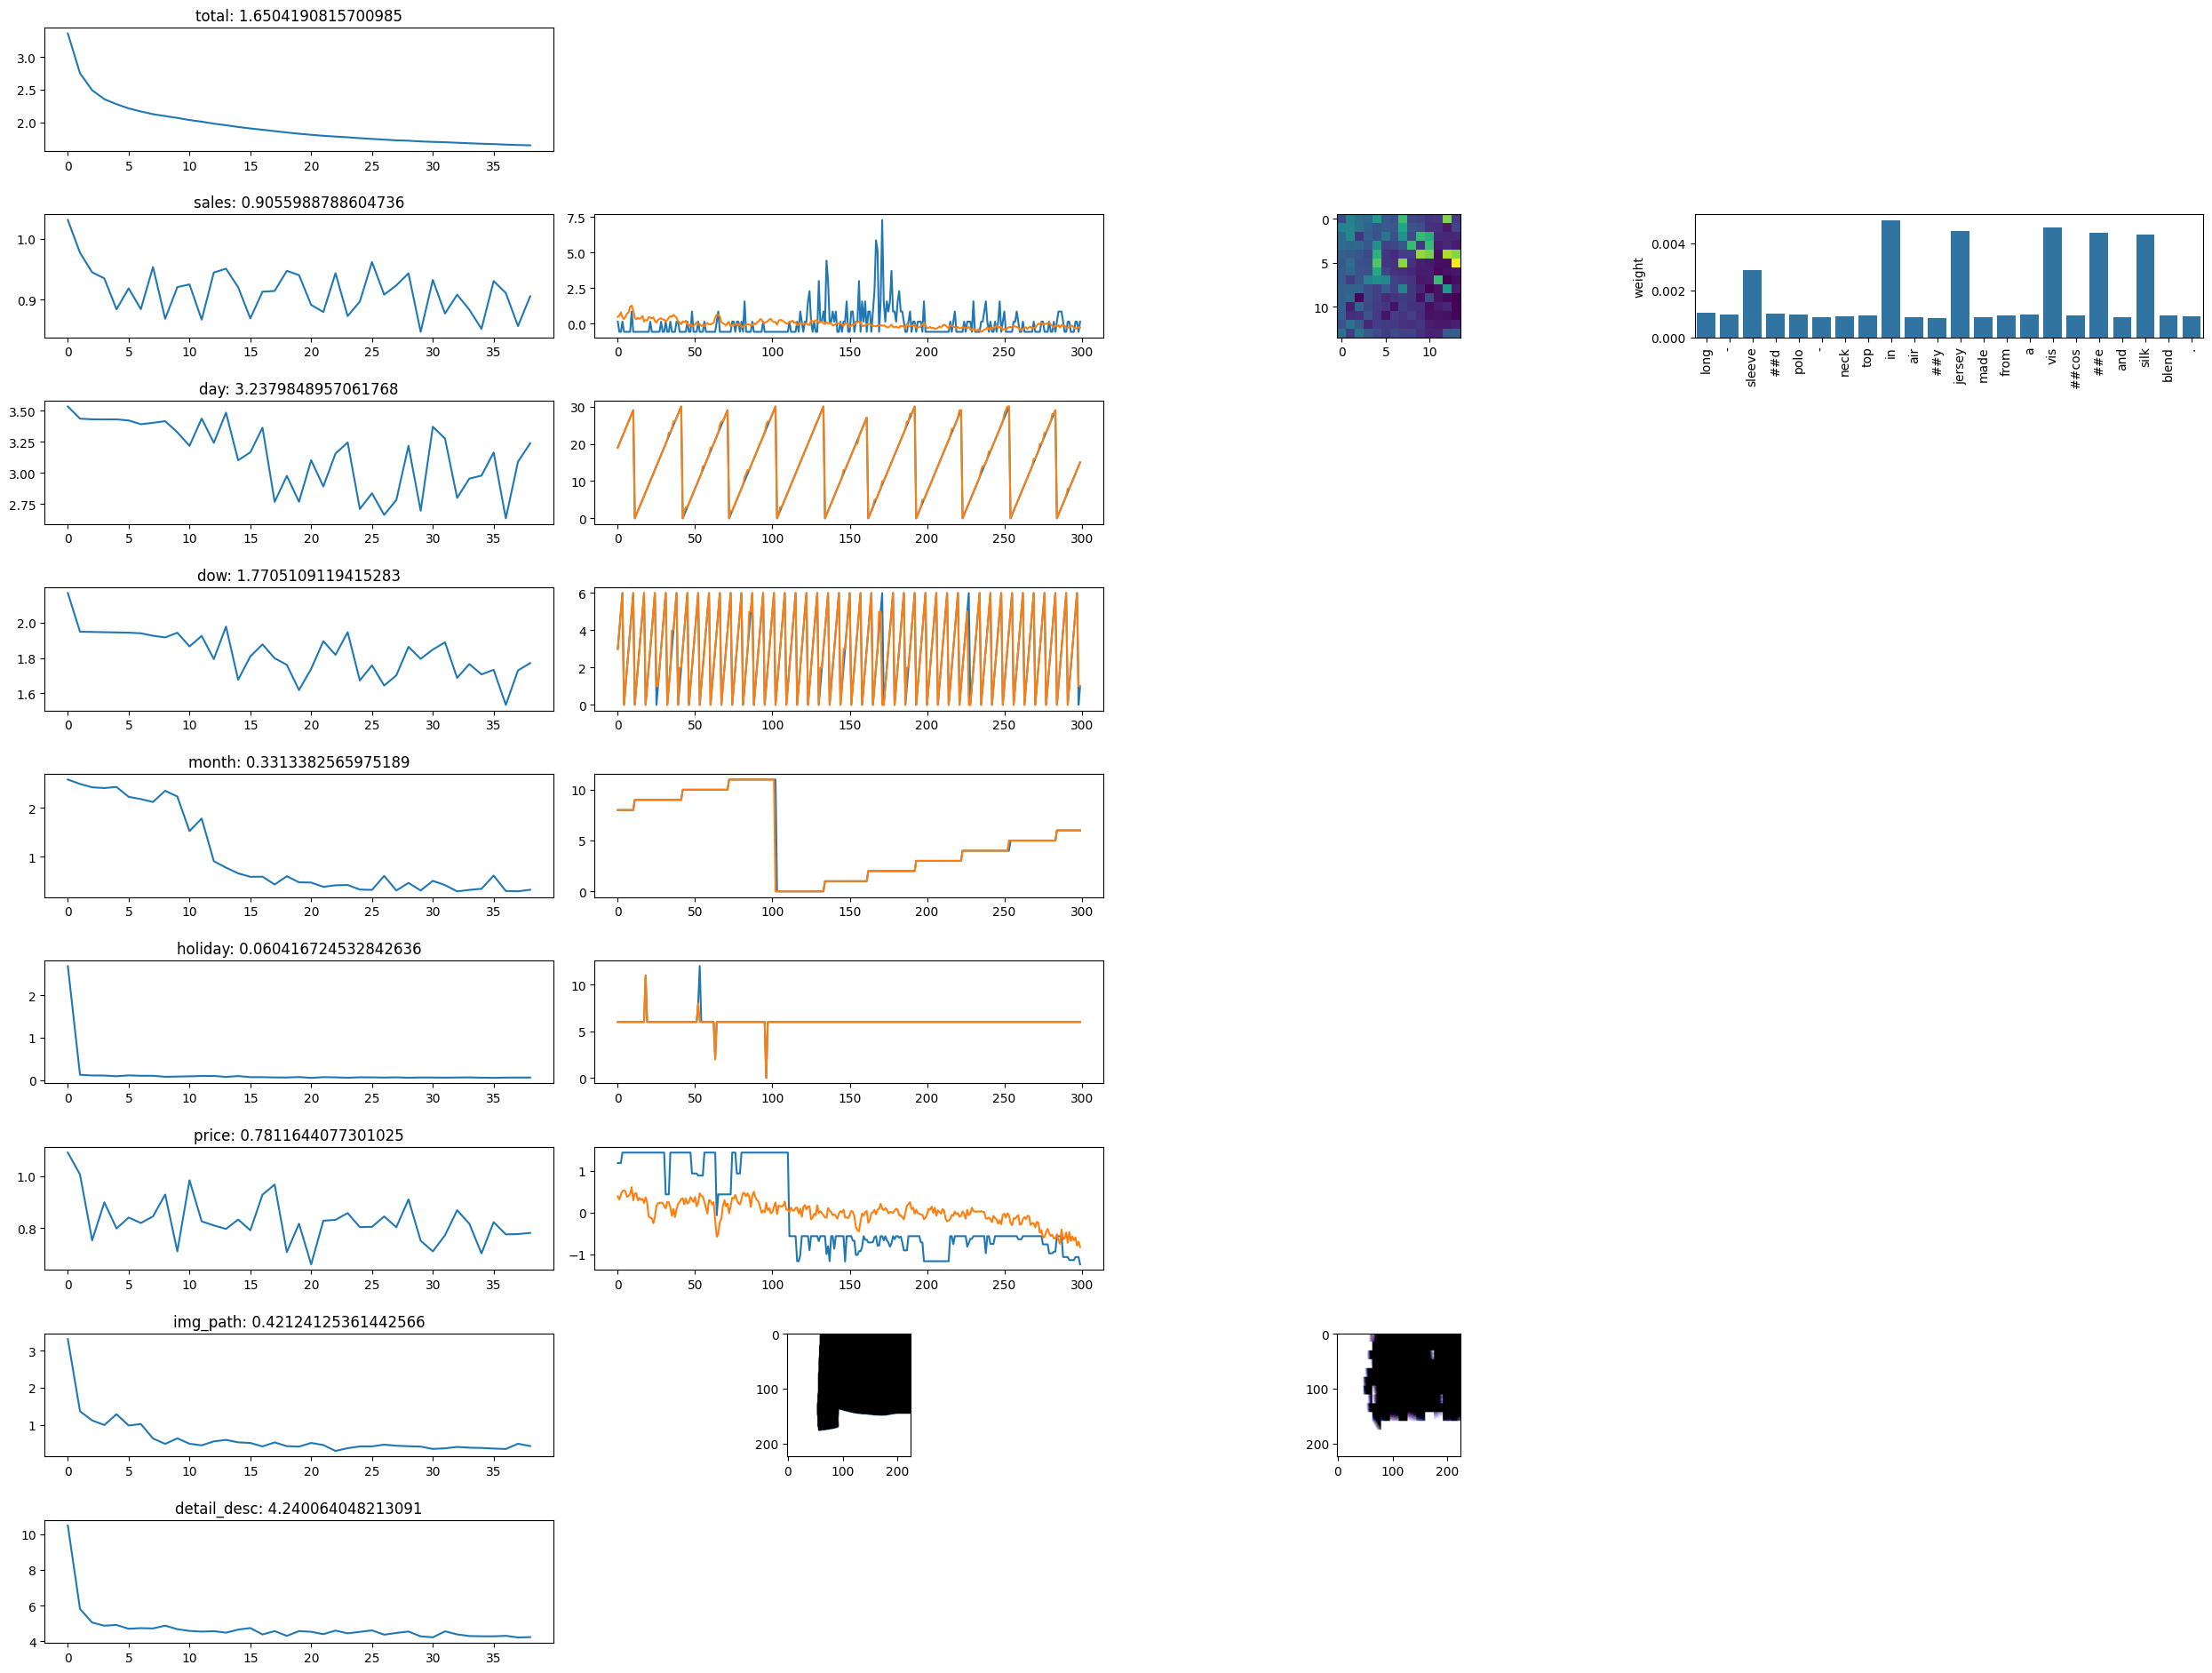

 85%|████████▌ | 778/915 [09:58<01:30,  1.51it/s]

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
epoch = 3

def train_epoch():
    pbar = tqdm(train_dataloader)
    model.train()
    for n, data_dict in enumerate(pbar):
        optimizer.zero_grad()
        output_dict, sa_weight_dict, ca_weight_dict, loss_dict = model(data_dict, device)
        loss = torch.stack([val for val in loss_dict.values()]).mean()
        loss.backward()
        optimizer.step()
        
        if n % 20 == 0: 
            get_loss_lists(loss, loss_dict)
            plot_sample(output_dict, data_dict, mean_loss_li_dict, ca_weight_dict)

for e in range(epoch):
    train_epoch()
    scheduler.step()

    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_model_epoch{e}_{now}"
        torch.save(model.state_dict(), path)